In [1]:
from __future__ import print_function

%pylab
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


# Diffusion fun

we are going to create an example of diffusion in a 2d plane

### firstly, we need to create the plane where the Diffusion will take place

In [2]:
dt = 0.1 # the time step
T = 30    # the final time

ds = 0.5  # the space step
w = 30    # the width of the frame
h = 30    # the height

W = int(w/ds)
H = int(h/ds)

In [3]:
t = linspace(0, T, int(T/dt))

In [4]:
# p represents the concentration at each point 
p = zeros(t.shape + (W,H))
p.shape

(300, 60, 60)

In [5]:
# we can slice the array to get one time frame of data
# for time = 0
p0 = p[0]
p0.shape

(60, 60)

In [6]:
# then we can index p0 like a 2d array
p0[1,4]

0.0

-------------------------------------

### Now we can do the actual diffusion
but first, some theory

the diffusion equation (for constant diffusion coefficient D) is given by the following differential equation

$ \cfrac{\mathrm{d} \phi}{\mathrm{d} t} = D \cdot \nabla^2 \phi$

in 2D this becomes 

$ \cfrac{\mathrm{d} \phi}{\mathrm{d} t} = D \cdot \left( \cfrac{\partial^2 \phi}{\partial x^2} + \cfrac{\partial^2 \phi}{\partial y^2} \right)$

then $\phi(t + \mathrm{d}t)$ is equal to

$ \phi(t + \mathrm{d}t) = \phi(t) + \mathrm{d}\phi $

and $\mathrm{d}\phi$ is

$ \mathrm{d}\phi = D \, \nabla^2 \phi \cdot \mathrm{d}t $

------------------------------

*but wait*, what exactly is the laplacian operator $\nabla^2$?

to figure that out we need to learn about Laplace equations:

$\nabla^2 \phi = 0$

simply put, the solutions of laplace equations have an interesting property,
that any point $\phi(x,y)$ will be equal to the average of $\phi$ around the point $(x,y)$

intuitively, the laplacian of a function gives some measure of the value of $\phi$ at a point vs the average of $\phi$ around that point

for some small area $\epsilon$ around $(x_0,y_0)$

$$\nabla^2 \phi \approx \frac{1}{\epsilon} \iint_{\epsilon} \phi(x,y) \; \mathrm{d}x\mathrm{d}y - \phi(x_0,y_0)$$

for our discrete example where density is given in cells, we can take the average sum of the neighboring cells

![grid](grid.png)

here the red cell is $(x_0, y_0)$ and the green cells are the neighbors. <br>
each cell has an area of $\mathrm{d}s^2$ and there are 4 of them so $\epsilon = 4 \mathrm{d}s^2$

the integral then becomes a sum and finally:

$$ \nabla^2 \phi \approx \frac{\phi[x_0+1, y_0] + \phi[x_0-1, y_0] + \phi[x_0, y_0+1] + \phi[x_0, y_0-1]}{4 \mathrm{d}s^2} - \frac{\phi[x_0, y_0]}{\mathrm{d}s^2} $$

notice the $\mathrm{d}s^2$ under the $\phi[x_0, y_0]$ because now it represents the entire area of the cell

---------------------------------------------

With that information we can calculate $\mathrm{d}\phi$

$ \mathrm{d}\phi = \frac{D}{\mathrm{d}s^2} \left( \frac{\phi[x_0+1, y_0] + \phi[x_0-1, y_0] + \phi[x_0, y_0+1] + \phi[x_0, y_0-1]}{4} - \phi[x_0, y_0] \right) \mathrm{d}t $

$D, \mathrm{d}s, \mathrm{d}t$ are constant so we can define some variable $k = D \cfrac{\mathrm{d}t}{\mathrm{d}s^2}$ and so

$ \mathrm{d}\phi = k \left( \frac{\phi[x_0+1, y_0] + \phi[x_0-1, y_0] + \phi[x_0, y_0+1] + \phi[x_0, y_0-1]}{4} - \phi[x_0, y_0] \right)$

then **finally**,

$ \phi[t + 1] = \phi[x, y] +  k \left( \frac{\phi[x+1, y] + \phi[x-1, y] + \phi[x, y+1] + \phi[x, y-1]}{4} - \phi[x, y] \right) \\
   = \left( 1 - k \right) \phi[x, y] +  k \frac{\phi[x+1, y] + \phi[x-1, y] + \phi[x, y+1] + \phi[x, y-1]}{4} $

now we are finally ready to create the implementation

---------------------------------------------

In [7]:
# first defining the variables
D = 0.5               # the diffusion coefficient
k = (D*dt)/(ds**2)  # the k variable from the formula

In [8]:
# this function returns the averaged sum of the neighbors of the cell (x,y) at time = t[i]
def avg_p(i, x, y):
    p_ = p[i]  # slice of p for time = t[i]
    
    nbs = []
    
    # to avoid clashing with the boundaries
    if x > 0:
        nbs.append(p_[x-1, y])
    if x < W - 1:
        nbs.append(p_[x+1, y])
    if y > 0:
        nbs.append(p_[x, y-1])
    if y < H - 1:
        nbs.append(p_[x, y+1])
        
    return sum(nbs)/len(nbs)

In [9]:
# it's useful to have x,y arrays for our formulas
x = linspace(-w/2, w/2, W)
y = linspace(-h/2, h/2, H)

In [10]:
# firstly, we have to set the initial conditions
for i in range(W):
    for j in range(H):
        x0 = x[i]
        y0 = y[j]
        
        p[0][i,j] = 5*(1- 2*random.rand())

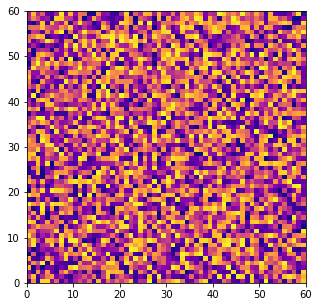

In [11]:
# to see the results we can plot it
plt.figure(figsize=(5,5))
plt.pcolormesh(p0, cmap='plasma')

In [12]:
# then we iteratively run the formula for every slice of time
for i in range(1, len(t)):
    for x0 in range(W):
        for y0 in range(H):
            p[i][x0,y0]  = (1-k) * p[i-1][x0,y0] + k * avg_p(i-1, x0, y0)


In [13]:
@interact(i = (0, len(t) - 1))
def plot_diff(i = 0):
    plt.figure(figsize=(11,9))
    plt.pcolormesh(p[i], vmin=np.min(p[0]), vmax=np.max(p[0]), cmap='plasma')
    plt.colorbar()
    plt.show()
    
# use the slider to change the time.

interactive(children=(IntSlider(value=0, description='i', max=299), Output()), _dom_classes=('widget-interact'…